c:\Users\miralles\AppData\Local\miniconda3\envs\qf\Lib\site-packages\statsmodels\tools\tools.py:6: UserWarning: A NumPy version >=1.23.5 and <2.3.0 is required for this version of SciPy (detected version 2.3.2)
  import scipy.linalg


1. DATA DOWNLOAD


[*********************100%***********************]  1 of 1 completed



Head of price data:
Price           Price
Ticker           AAPL
Date                 
2020-01-02  72.538498
2020-01-03  71.833305
2020-01-06  72.405670
2020-01-07  72.065170
2020-01-08  73.224419
----------------------------------------------------------------------

2. RETURNS COMPUTATION
Head of returns data:
Price           Price   Returns
Ticker           AAPL          
Date                           
2020-01-03  71.833305 -0.972163
2020-01-06  72.405670  0.796796
2020-01-07  72.065170 -0.470267
2020-01-08  73.224419  1.608611
2020-01-09  74.779747  2.124057
----------------------------------------------------------------------

3. ACF & PACF (nlags = 20)
Correlogram (lags 1..20):
       acf    pacf        Q   p-val
0  -0.1510 -0.1512  17.2834  0.0000
1   0.0272  0.0045  17.8431  0.0001
2  -0.0256 -0.0215  18.3425  0.0004
3  -0.0211 -0.0291  18.6818  0.0009
4   0.0632  0.0582  21.7244  0.0006
5  -0.0789 -0.0630  26.4758  0.0002
6   0.0938  0.0733  33.1942  0.0000
7  -0.1386 -0.116

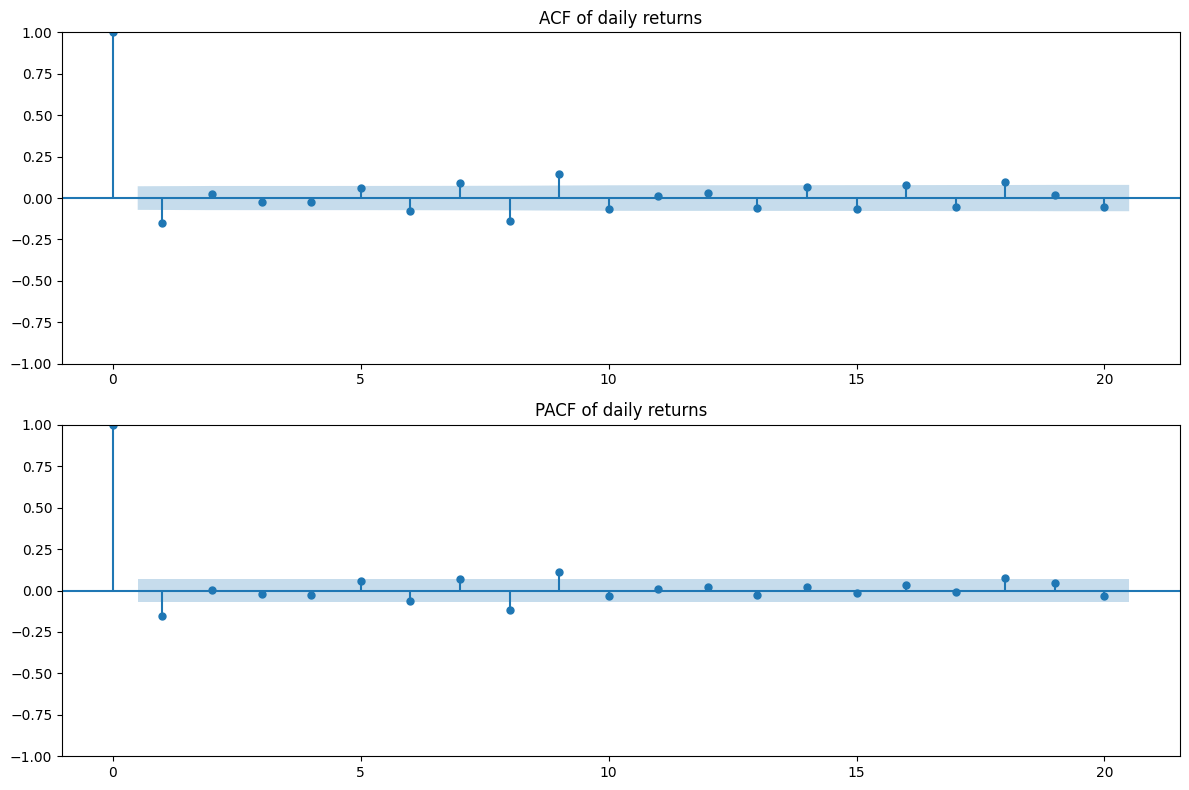


Interpretation (ACF/PACF):
----------------------------------------------------------------------
The autocorrelation (ACF) and partial autocorrelation (PACF) analysis shows a pronounced peak
at the first lag and values close to zero at subsequent lags. Although most coefficients fall
within the confidence bands, some specific lags exceed them, indicating statistically significant
dependencies at certain points. Hence, returns are not completely random, which justifies
estimating an ARMA model to capture this temporal structure.

The correlogram table reinforces this: the Ljung-Box Q-statistic shows very low p-values (< 0.05)
for multiple lags, especially between lags 1 and 10, suggesting significant global autocorrelation
not explained by white noise.
----------------------------------------------------------------------

4. MODEL SELECTION (AIC & BIC) | Grid: ARMA(p,q), p,q ∈ {0..4}

AIC table by model:
          0         1         2         3         4
0  3420.103  3405.710  3407.

In [1]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
import statsmodels.tsa.api as smt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.stats.diagnostic import acorr_ljungbox
import warnings
warnings.filterwarnings("ignore")

# 1) Download Apple (AAPL) data from 01/01/2020 - 01/01/2023
print("="*70)
print("1. DATA DOWNLOAD")
print("="*70)
data = yf.download("AAPL", start="2020-01-01", end="2023-01-01", auto_adjust=True)
data = data[["Close"]]
data.rename(columns={"Close": "Price"}, inplace=True)
print("\nHead of price data:")
print(data.head().to_string())
print("-"*70)

# 2) Calculate daily returns in percentage
print("\n2. RETURNS COMPUTATION")
print("="*70)
data["Returns"] = 100 * data["Price"].pct_change()
data.dropna(inplace=True)
print("Head of returns data:")
print(data.head().to_string())
print("-"*70)

# 3) Calculate and plot the ACF and PACF up to 20 lags
print("\n3. ACF & PACF (nlags = 20)")
print("="*70)
acf, q, pval = smt.acf(data["Returns"], nlags=20, qstat=True)
pacf = smt.pacf(data["Returns"], nlags=20)
correlogram = pd.DataFrame({'acf': acf[1:], 'pacf': pacf[1:], 'Q': q, 'p-val': pval})
print("Correlogram (lags 1..20):")
# Format to 4 decimals for readability
print(correlogram.round(4).to_string(index=True))

fig, axes = plt.subplots(2, 1, figsize=(12, 8))
plot_acf(data["Returns"], lags=20, ax=axes[0])
axes[0].set_title("ACF of daily returns")
plot_pacf(data["Returns"], lags=20, ax=axes[1])
axes[1].set_title("PACF of daily returns")
plt.tight_layout()
plt.show()

analysis_text = """
The autocorrelation (ACF) and partial autocorrelation (PACF) analysis shows a pronounced peak
at the first lag and values close to zero at subsequent lags. Although most coefficients fall
within the confidence bands, some specific lags exceed them, indicating statistically significant
dependencies at certain points. Hence, returns are not completely random, which justifies
estimating an ARMA model to capture this temporal structure.

The correlogram table reinforces this: the Ljung-Box Q-statistic shows very low p-values (< 0.05)
for multiple lags, especially between lags 1 and 10, suggesting significant global autocorrelation
not explained by white noise.
"""
print("\nInterpretation (ACF/PACF):")
print("-"*70)
print(analysis_text.strip())
print("-"*70)

# 4) Select the best ARMA model using AIC and BIC (ARMA(0,0) to ARMA(4,4))
print("\n4. MODEL SELECTION (AIC & BIC) | Grid: ARMA(p,q), p,q ∈ {0..4}")
print("="*70)
order_selection = smt.arma_order_select_ic(
    data["Returns"], max_ar=4, max_ma=4, ic=["aic", "bic"], trend='n'
)

print("\nAIC table by model:")
print(order_selection.aic.round(3))
print("\nBIC table by model:")
print(order_selection.bic.round(3))
print(f"\n→ Optimal model by AIC: ARMA{order_selection.aic_min_order}")
print(f"→ Optimal model by BIC: ARMA{order_selection.bic_min_order}")
print("-"*70)

# 5) Estimate the model (according to AIC)
print("\n5. MODEL ESTIMATION (using AIC-optimal order)")
print("="*70)
optimal_order = order_selection.aic_min_order
model = sm.tsa.ARIMA(data["Returns"], order=(optimal_order[0], 0, optimal_order[1]))
result = model.fit()
print("Summary of the selected ARMA model:\n")
print(result.summary())
print("-"*70)

# 6) Ljung-Box test on residuals
print("\n6. DIAGNOSTICS: Ljung-Box test on residuals (lag=20)")
print("="*70)
ljung_box_result = acorr_ljungbox(result.resid, lags=[20], return_df=True)
print(ljung_box_result.round(4).to_string(index=False))
pval = ljung_box_result['lb_pvalue'].values[0]
print("-"*70)

# 7) Interpretation
print("\n7. INTERPRETATION")
print("="*70)
print(f"Chosen model: ARMA{optimal_order} (by AIC).")
print(f"Ljung-Box p-value at lag 20: {pval:.4f}")
if pval > 0.05:
    print("✅ Residuals show no significant autocorrelation → model is adequate.")
else:
    print("⚠ Residuals show significant autocorrelation → model may be misspecified.")
print("="*70)
